# Module 2 - Noise Filtration/Reduction

In this notebook, we demonstrate how to use **pysofi** to apply noise filtration on a series of image stacks. In SOFI 2.0 pipeline, noise filtration step is carried out after the [moment-/cumulant-reconstruction]() and [shrinking kernel deconvolution]() step. 

Photobleaching of fluorescent probes is a general concern for super-resolution imaging analysis methods. Besides [bleaching correction](), one way to reduce the affect of photobleaching on analysis is to divide a long video into blocks with fewer frames. In each block, the decrease in fluorescence intensity is small enough for users to omit the effect of photobleaching. 

The moment-/cumulant-reconstruction step is performed on each block independently, each yield a single frame for further process. Due to the fact that the reconstructed image yielded from each individual block is severely degraded by noise, we add a step of noise filtration along the time axis for each pixel independently by taking the convolution with a Gaussian kernel. The noise filter is applied along the time axis for each pixel independently.

## 1. Load data blocks into seperate Data objects.

Our dataset is composed of 20 tiff videos in sequence ('Block1.tif' to 'Block20.tif'), and each video has 200 frames. First, we generate a list of filenames by their sequence, and load all videos into a dictionary (dset), where keys are filenames in the list (e.g. 'Block1.tif') and values are Data objects.

In [4]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from functions import data, filtering, masks
%matplotlib inline
%load_ext autoreload
%autoreload 2

filenum = 20
filepath = '../sampledata'
filenames = ['Block' + str(i+1) + '.tif' for i in range(filenum)]
dset = {}

for filename in filenames:
    dset[filename] = data.Data(filepath, filename)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Besides after moment-reconstructions and shrinking kernel deconvolution, the user can choose to add in the noise filtration step any time on any image series during the analysis to reduce noise.

In this notebook, we first generate moment-reconstructions for each block, then carry out noise filtration.

## 2. Generate moment-reconstructed image for each block.

For more details on moment- and cumulant-reconstruction, please refer to this [notebook](). We save all reconstructions in one dictionary <code>m_set</code>, where keys are filenames and values are images.

In [56]:
m_set = {}
for filename in filenames:
    print('\n' + 'Calculating ' + filename + '...')
    m_set[filename] = dset[filename].moment_image(order=6, finterp=False)


Calculating Block1.tif...
[=============================] 100.0%
Calculating Block2.tif...
[=============================] 100.0%
Calculating Block3.tif...
[=============================] 100.0%
Calculating Block4.tif...
[=============================] 100.0%
Calculating Block5.tif...
[=============================] 100.0%
Calculating Block6.tif...
[=============================] 100.0%
Calculating Block7.tif...
[=============================] 100.0%
Calculating Block8.tif...
[=============================] 100.0%
Calculating Block9.tif...
[=============================] 100.0%
Calculating Block10.tif...
[=============================] 100.0%
Calculating Block11.tif...
[=============================] 100.0%
Calculating Block12.tif...
[=============================] 100.0%
Calculating Block13.tif...
[=============================] 100.0%
Calculating Block14.tif...
[=============================] 100.0%
Calculating Block15.tif...
[=============================] 100.0%
Calculating Block1

## 3. Noise Filtration.

Noise filtration is carried out along the time axis for each pixel independently by taking the convolution with a Gaussian kernel.

We can generate a one-dimensional Gaussian mask with a defined shape and $\sigma$ by calling the function <code>masks.gauss1D_mask</code>, and conduct filtering with <code>filtering.noise_filter1d</code>. The sequence The number of frames does not change after the noise filtering, and each frame is saved to the corresponding Data object as an attribute. The parameters for function <code>filtering.noise_filter1d</code> are:
+ <code>dset</code>: a dictionary of Data objects that we define when loading data.
+ <code>im_set</code>: a dictionary of images need to be filtered. In our case, keys are filenames and values are moments-reconstructions after fourier interpolation.
+ <code>noise_filter</code>: filtering kernel. The default is a 1D Gaussian kernel with $shape = (1, 21)$ and $\sigma = 2$.
+ <code>filtername</code>: name of the filtered image that add to the Data object as an attribute.
+ <code>filenames</code>: keys (filenames) in im_set. The user can define the correct sequence.
+ <code>return_option</code>: besides add filtered images to Data objects, whether to return them in a 3D array.

In [57]:
# Sequence of files for noise filtration
filenames = [*m_set]
print(filenames)

['Block1.tif', 'Block2.tif', 'Block3.tif', 'Block4.tif', 'Block5.tif', 'Block6.tif', 'Block7.tif', 'Block8.tif', 'Block9.tif', 'Block10.tif', 'Block11.tif', 'Block12.tif', 'Block13.tif', 'Block14.tif', 'Block15.tif', 'Block16.tif', 'Block17.tif', 'Block19.tif', 'Block18.tif', 'Block20.tif']


In [58]:
# Noise filtering on M6 seriers
nf = masks.gauss1d_mask(shape = (1,21), sigma = 2)
m_filtered = filtering.noise_filter1d(dset, m_set, nf, return_option=True)

Noise filtering ...
[====================] 100%

We set <code>return_option=True</code> to return the filtered images in a 3D array.

Here the filenames are in the correct order as we want and do not need any changes. The user can also set the order and feed it to the function. For example, if the user want to have 'Block19.tif' come before 'Block18.tif', we can set 
<pre><code>filenames = [*m_set]
filenames = [filenames[i] for i in list(range(17))+[18,17,19]]
m_filtered = filtering.noise_filter1d(dset, m_set, nf, filenames=filenames)
</code></pre>

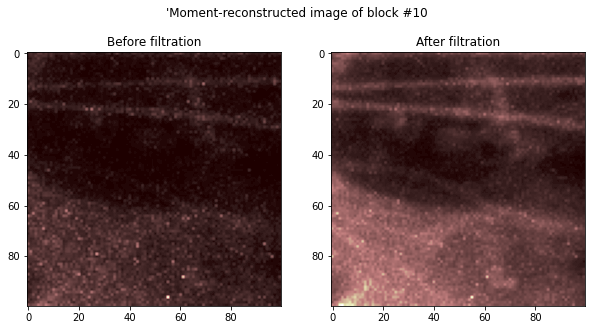

In [66]:
# Show images of block 10 before and after the filtration
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Moment-reconstructed image of block #10")
axs[0].set_title('Before filtration')
axs[0].imshow(m_set['Block10.tif'][100:200, 100:200], cmap='pink')

axs[1].set_title('After filtration')
axs[1].imshow(m_filtered[9][100:200, 100:200], cmap='pink')
plt.show() 

The noise filtration is carreid out along the time axis. We are also happy to see that it helps to smoothen and restore some details in moment-reconstructed images.

As mentioned before, the user can add in the noise filtration step any time throughout the image analysis pipeline. Besides moment-reconstructed images, here we can also filter on the average image of each block.

In [72]:
ave_im_set = {}
for filename in filenames:
    print('\n' + 'Calculating ' + filename + '...')
    ave_im_set[filename] = dset[filename].ave


Calculating Block1.tif...

Calculating Block2.tif...

Calculating Block3.tif...

Calculating Block4.tif...

Calculating Block5.tif...

Calculating Block6.tif...

Calculating Block7.tif...

Calculating Block8.tif...

Calculating Block9.tif...

Calculating Block10.tif...

Calculating Block11.tif...

Calculating Block12.tif...

Calculating Block13.tif...

Calculating Block14.tif...

Calculating Block15.tif...

Calculating Block16.tif...

Calculating Block17.tif...

Calculating Block19.tif...

Calculating Block18.tif...

Calculating Block20.tif...


In [74]:
nf = masks.gauss1d_mask(shape = (1,21), sigma = 2)
ave_im_filtered = filtering.noise_filter1d(dset, ave_im_set, nf, return_option=True)

Noise filtering ...
[====================] 100%

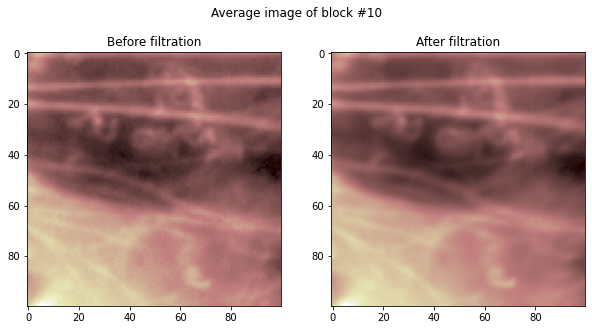

In [75]:
# Show images of block 10 before and after the filtration
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Average image of block #10")
axs[0].set_title('Before filtration')
axs[0].imshow(ave_im_set['Block10.tif'][100:200, 100:200], cmap='pink')

axs[1].set_title('After filtration')
axs[1].imshow(ave_im_filtered[9][100:200, 100:200], cmap='pink')
plt.show() 